In [1]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import numpy as np

from ops import *   # part of the current code, ops.py, 
from utils import * # part of the current code, utils.py
import os 
import time
from glob import glob
#from scipy.misc import imsave as ims  # I had to comment it not to receive error
from random import randint 
from data_providers import * 
slim = tf.contrib.slim #TF-Slim is like KERAS, a library that makes building, training and evaluation neural networks simple. \
import scipy as sp
import pickle
from tensorflow.keras import datasets
import tensorflow.data as td
from tqdm import tqdm_notebook as tqdm # تقدم


config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.3),
    device_count = {'GPU': 1}
)



'''Keras function to download mnist'''
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data() # Load Data
train_images, test_images = np.float32(train_images / 255.0), np.float32(test_images / 255.0) # 0 to 1 instead of 0 to 255


    

Populating the interactive namespace from numpy and matplotlib


In [2]:
params = {
    'batch_size':64,  
    'image_dim':28*28*1, 
    'imageshape': [64,28,28,1], 
    'c':1,
    'h':28,
    'w':28,
    'epochs':20, 
    'noise_dim':64
}


In [3]:
# DataLoader and iterator
batch = td.Dataset.from_tensor_slices(train_images).shuffle(len(train_images), reshuffle_each_iteration=True).repeat().batch(params['batch_size'], drop_remainder=True).prefetch(10)
print('Dataset Object:', batch)
iterator = batch.make_initializable_iterator()
batch_images = iterator.get_next()
print('Iterator:', batch_images)


# Placeholders for input 
gen_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='input_noise')
m_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='m_input')
n_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='n_input')




Dataset Object: <DatasetV1Adapter shapes: (64, 28, 28), types: tf.float32>
Iterator: Tensor("IteratorGetNext:0", shape=(64, 28, 28), dtype=float32)


In [4]:

'''Notice that unlike usual GAN, this is not a binary classifier. The output is a vector of dim 3.'''
def discriminator(z, z_dim=params['noise_dim'], reuse=False, training=True):
    
    with tf.variable_scope("disc") as scope:
        if reuse:
                scope.reuse_variables() 
      
        h0 = z  
        h1 = lrelu(slim.fully_connected(h0, int(z_dim/2))) 
        h1 = slim.dropout(h1, keep_prob=0.5, is_training=training)
        h2 = lrelu(slim.fully_connected(h1, int(z_dim/4))) 
        h2 = slim.dropout(h2, keep_prob=0.5, is_training=training) 
        h3 = slim.fully_connected(h2, 3) 

        return h3  
    
    
def encoder(image, z_dim=params['noise_dim'], batchsize=params['batch_size'], h=params['h'], w=params['w'], c=params['c'], df_dim=16):
    with tf.variable_scope("encoder") as scope:

        h0 = image ### updated: 28x28X1
        h0 = lrelu(conv2d(h0, 1, df_dim, name='d_h0_conv')) #### 14x14x16 shape
        h1 = lrelu(conv2d(h0, df_dim, df_dim*2, name='d_h1_conv')) #### 7 x 7 x 32 = 1568
        h2 = tf.reshape(h1, [batchsize, -1]) ### 1568
        z = dense(h2, 1568, z_dim, scope='d_h3_lin_mu')   ##### 1568 to noise_dim

        return z
    


        
def generator(z,z_dim=params['noise_dim'],batchsize=params['batch_size'],h=params['h'],w=params['w'],c=params['c'],gf_dim=16,reuse=False):
    with tf.variable_scope("gen") as scope:
        if reuse:
                scope.reuse_variables()
        z2 = dense(z, z_dim, 1568, scope='g_h0_lin') 

        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.reshape(z2, [-1, 7, 7, gf_dim*2]))) # 7x7x32

        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv_transpose(h0, [batchsize, 14, 14, gf_dim], "g_h1"))) #14*14*16

        h2 = tf.nn.sigmoid(conv_transpose(h1, [batchsize, h, w, c], "g_h2"))  ### 
        
        return h2  

In [5]:
import tensorflow_probability as tfp
import math
tf.reset_default_graph()

tfd = tfp.distributions
class_num = 10
c_const = 9.9
sigma_const = 0.005
gm_mus = np.eye(class_num, params['noise_dim'])* c_const

gm_mus = gm_mus.tolist()
## Let mean of each Gaussian be an indicator, aka one hot code
gm_sigma = sigma_const
gm_cov_diag = np.eye(class_num, params['noise_dim']) * gm_sigma * gm_sigma
gm_cov_diag = gm_cov_diag.tolist()






mix = 1.0/class_num ### mixing coef
gm_probs = np.repeat(mix, class_num) ## The vector of mixing_probs
        
gm_distr = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=gm_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=gm_mus, scale_diag=gm_cov_diag)
)

# DataLoader and iterator
batch = td.Dataset.from_tensor_slices(train_images).shuffle(len(train_images), reshuffle_each_iteration=True).repeat().batch(params['batch_size'], drop_remainder=True).prefetch(10)
print('Dataset Object:', batch)
iterator = batch.make_initializable_iterator()
batch_images = iterator.get_next()
batch_images = tf.reshape(batch_images, [64,28,28,1])


print('Iterator:' ,batch_images)


# Placeholders for input 
gen_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='input_noise')
m_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='m_input')
n_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='n_input')


# Build VAE Network
z = encoder(batch_images)
eps = gm_distr.sample(params['batch_size'])
#eps = tf.random_normal((params['batch_size'], params['noise_dim']), 0, 1, dtype=tf.float32)
#z = mu+(tf.sqrt(tf.exp(log_sigma_sq))* eps)
gen_sample = generator(z)
print("gen_sample", gen_sample.shape)
# Random Sampler
gen_rv = generator(gen_input,reuse=True)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(eps)
disc_fake = discriminator(z,reuse=True)
disc_m = discriminator(eps+m_input,reuse=True)
disc_m_gen = discriminator(z+n_input,reuse=True)

# Build Loss



a = np.tile([1.,0.,0.],params['batch_size'])
b = np.tile([0.,1.,0.],params['batch_size'])
c = np.tile([0.,0.,1.],params['batch_size'])
label_a = tf.reshape(a,[params['batch_size'],3])
label_b = tf.reshape(b,[params['batch_size'],3])
label_c = tf.reshape(c,[params['batch_size'],3])

disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_real, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_fake, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m, labels=label_c))
disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))
dloss = disc_loss_1 + disc_loss_2 + disc_loss_3 + disc_loss_4

r_p_m = (tf.nn.softmax(disc_m_gen)[:,0])*1.0/(tf.nn.softmax(disc_m_gen)[:,2])
r_q_m = (tf.nn.softmax(disc_m_gen)[:,1])*1.0/(tf.nn.softmax(disc_m_gen)[:,2])

sbd = tf.square(r_p_m - 1) - tf.square(r_q_m - 1) - 2*(r_q_m-1)*(r_p_m-r_q_m)
sbd_loss = tf.reduce_mean(sbd)
#kld = -0.5 * tf.reduce_sum(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), 1)
BCE = -tf.reduce_sum(tf.reshape(batch_images, [params['batch_size'], -1]) * tf.log(1e-10 + tf.reshape(gen_sample, [params['batch_size'], -1]))
                           + (1-tf.reshape(batch_images, [params['batch_size'], -1])) * tf.log(1e-10 + 1 - tf.reshape(gen_sample, [params['batch_size'], -1])),1)
vaeloss = tf.reduce_mean(sbd + BCE)
      
#Build Optimizers
t_vars = tf.trainable_variables()
e_vars = [var for var in t_vars if 'encoder' in var.name]
g_vars = [var for var in t_vars if 'gen' in var.name]
d_vars = [var for var in t_vars if 'disc' in var.name]

learningrate_gen = 1e-4
learningrate = 1e-4
beta1 = 0.5
g_optim = tf.train.AdamOptimizer(learningrate_gen, beta1=beta1).minimize(vaeloss, var_list=g_vars+e_vars)
d_optim = tf.train.AdamOptimizer(learningrate,     beta1=beta1).minimize(dloss, var_list=d_vars)

#Initialize
start_time = time.time()
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(iterator.initializer)



Dataset Object: <DatasetV1Adapter shapes: (64, 28, 28), types: tf.float32>
Iterator: Tensor("Reshape:0", shape=(64, 28, 28, 1), dtype=float32)
gen_sample (64, 28, 28, 1)



Epoch: [ 0] [ 936/ 937] time: 74.3730, dloss: 1.9164, gloss: 206.9519,SBD: 0.0001


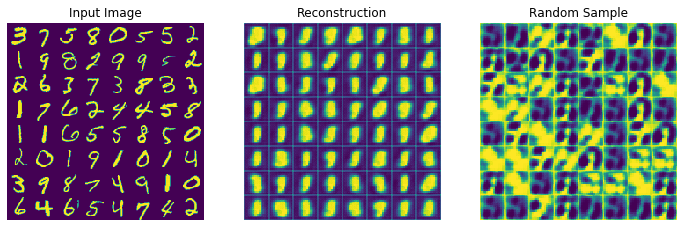


Epoch: [ 1] [ 936/ 937] time: 139.3942, dloss: 1.3461, gloss: 160.2143,SBD: 0.0002


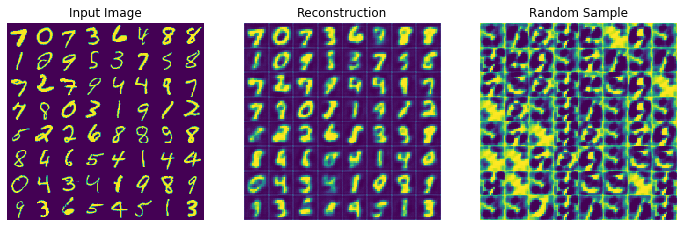


Epoch: [ 2] [ 936/ 937] time: 199.3977, dloss: 1.2950, gloss: 148.1101,SBD: 0.0000


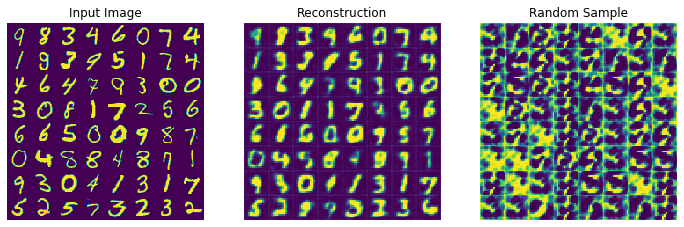


Epoch: [ 3] [ 936/ 937] time: 258.6754, dloss: 1.2186, gloss: 139.8437,SBD: -0.0000


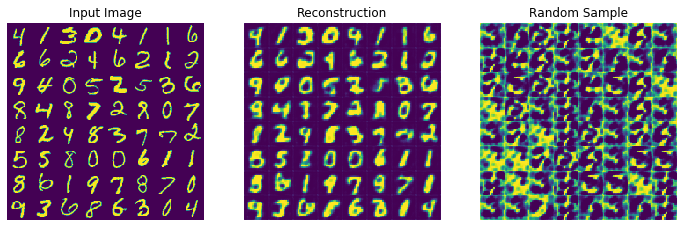


Epoch: [ 4] [ 936/ 937] time: 316.8221, dloss: 1.1864, gloss: 135.9253,SBD: -0.0000


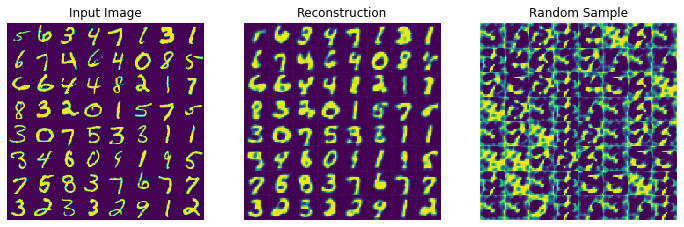


Epoch: [ 5] [ 936/ 937] time: 374.7475, dloss: 1.1729, gloss: 129.3432,SBD: 0.2087


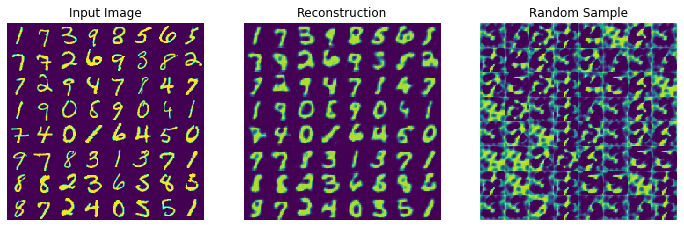


Epoch: [ 6] [ 936/ 937] time: 432.7422, dloss: 1.1595, gloss: 134.8950,SBD: -0.0000


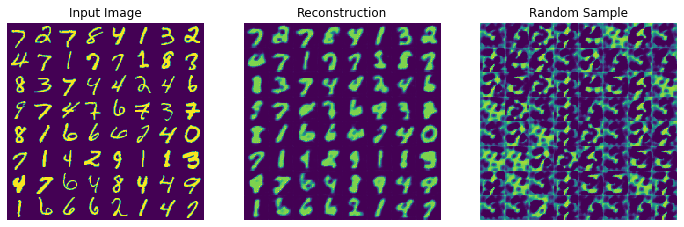


Epoch: [ 7] [ 936/ 937] time: 489.8031, dloss: 1.2296, gloss: 281.6460,SBD: 153.6191


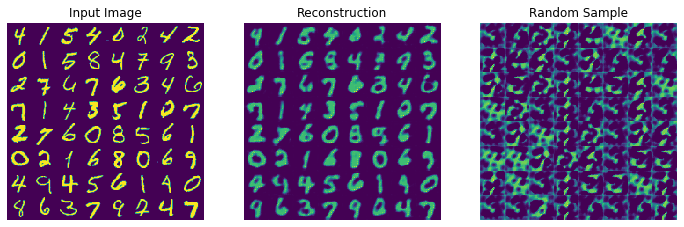


Epoch: [ 8] [ 936/ 937] time: 547.4204, dloss: 1.1462, gloss: 125.2089,SBD: -0.0000


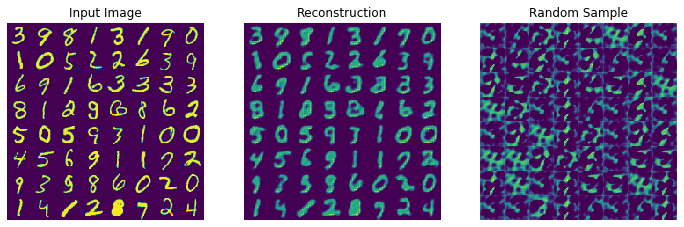


Epoch: [ 9] [ 936/ 937] time: 604.3996, dloss: 1.1591, gloss: 116.4993,SBD: 0.0000


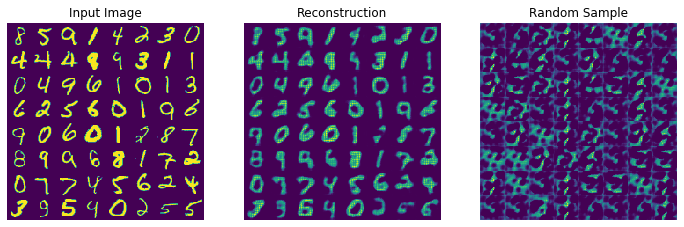


Epoch: [10] [ 936/ 937] time: 661.8957, dloss: 1.1280, gloss: 105.5986,SBD: 0.0000


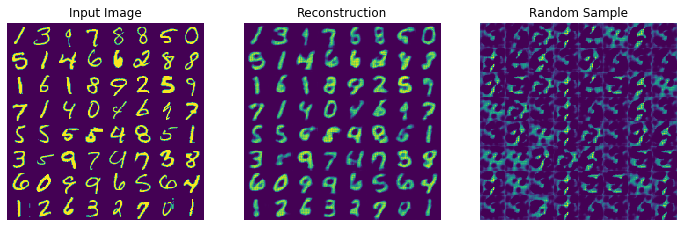


Epoch: [11] [ 936/ 937] time: 718.7178, dloss: 1.1248, gloss: 103.3978,SBD: 0.0000


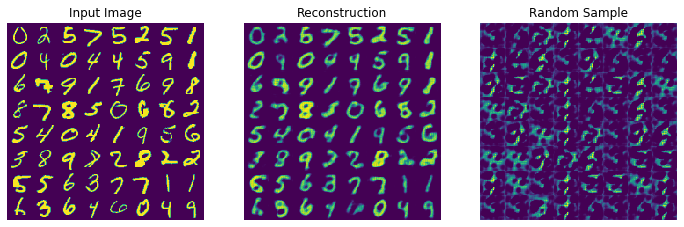


Epoch: [12] [ 936/ 937] time: 775.4271, dloss: 1.1361, gloss: 99.1251,SBD: 0.0000


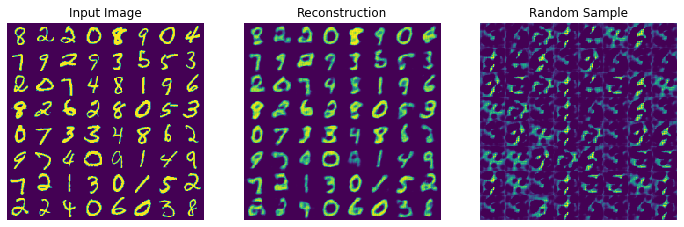


Epoch: [13] [ 936/ 937] time: 832.2374, dloss: 1.1103, gloss: 98.8136,SBD: 0.0000


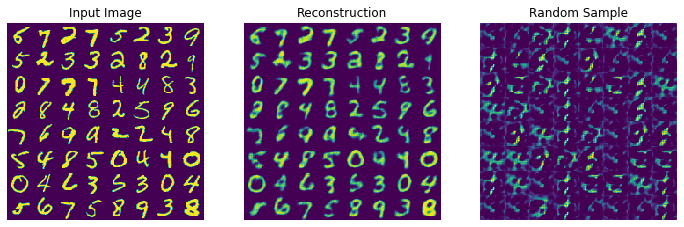


Epoch: [14] [ 936/ 937] time: 888.7062, dloss: 1.1964, gloss: 99.6050,SBD: 0.0000


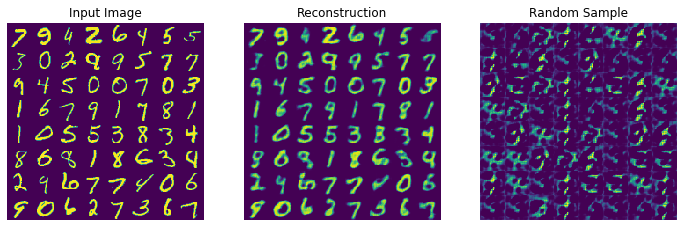


Epoch: [15] [ 936/ 937] time: 945.2349, dloss: 1.2314, gloss: 960.0938,SBD: 862.6449


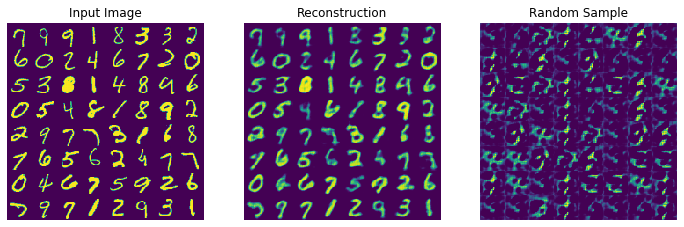


Epoch: [16] [ 936/ 937] time: 1002.3388, dloss: 1.1553, gloss: 98.0824,SBD: 0.0000


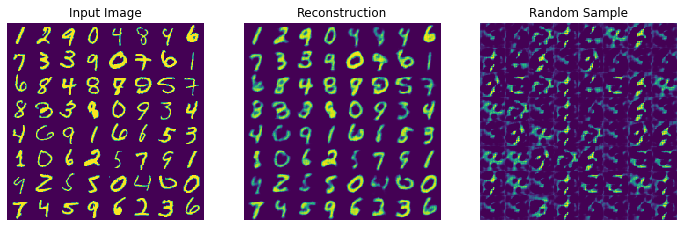


Epoch: [17] [ 936/ 937] time: 1060.6880, dloss: 1.1474, gloss: 100.4717,SBD: 0.0000


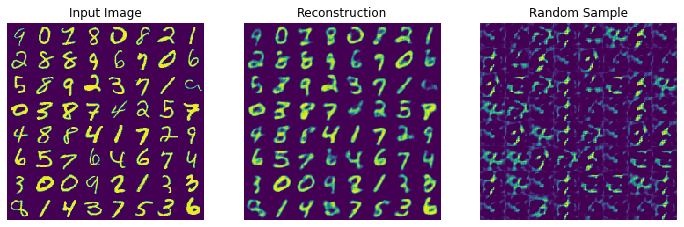


Epoch: [18] [ 936/ 937] time: 1118.1334, dloss: 1.1255, gloss: 96.1769,SBD: 0.0000


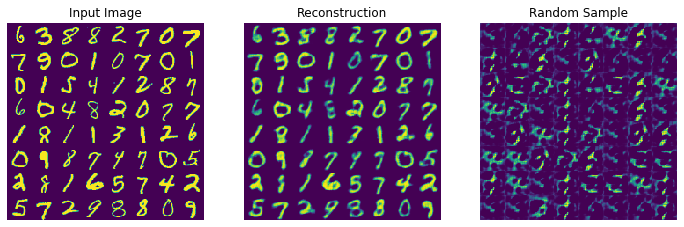


Epoch: [19] [ 936/ 937] time: 1176.8819, dloss: 1.1500, gloss: 96.8094,SBD: 0.0000


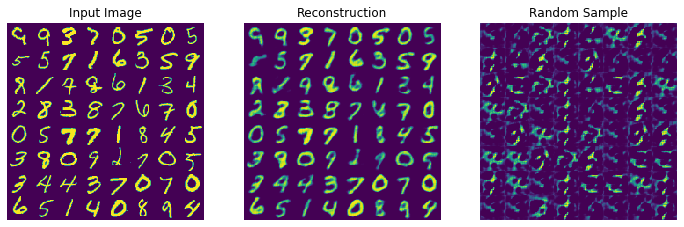

In [6]:
#from ipywidgets import IntProgress
# '------Training VAE and SBD Networks--------------------'
with sess.as_default():
    batch_z = gm_distr.sample(params['batch_size']).eval()
#np.random.uniform(-1, 1, [params['batch_size'], params['noise_dim']]).astype(np.float32) 
num_batches = int(len(train_images)/params['batch_size'])
dl,gl,sl=0,0,0
for epoch in tqdm(xrange(params['epochs'])):
    for idx in tqdm(range(num_batches)):
        
        sigma_n = 3.0 * c_const * 12.0 * sigma_const
        n_cov = np.eye(params['noise_dim'], params['noise_dim'])*sigma_n *sigma_n
        n_mean = np.repeat(0.0, params['noise_dim'])
        m = np.random.multivariate_normal(n_mean, n_cov, params['batch_size'])#Updated
        #m = np.random.normal(0, .01, size=[params['batch_size'], params['noise_dim']])
        #n_ = np.random.normal(0, .01, size=[params['batch_size'], params['noise_dim']])
        
        sigma_n = 3.0 * c_const * 12.0 * sigma_const
        n_cov = np.eye(params['noise_dim'], params['noise_dim'])*sigma_n *sigma_n
        n_mean = np.repeat(0.0, params['noise_dim'])
        n_ = np.random.multivariate_normal(n_mean, n_cov, params['batch_size'])#Updated


        # Train
        feed_dict = {m_input: m, n_input: n_}
        for _ in range(4):
            sess.run([d_optim],feed_dict=feed_dict)
        _, _, gl, dl, sl = sess.run([d_optim, g_optim, vaeloss, dloss, sbd_loss],
                                feed_dict=feed_dict)
        
        
#     '---------Printing intermediate results-------------'      
    if epoch % 1 == 0:
        
        print("Epoch: [%2d] [%4d/%4d] time: %4.4f, dloss: %4.4f, gloss: %4.4f,SBD: %4.4f" % (epoch, idx, num_batches, time.time() - start_time, dl,gl,sl))
        
        images = sess.run([batch_images,gen_sample,gen_rv],feed_dict = {gen_input: batch_z})
        fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
        t = ['Input Image', 'Reconstruction', 'Random Sample']
        for i,image in enumerate(images):
            sdata = np.expand_dims(image,0)
            img = merge(sdata[0],[8,8])
            ax[i].imshow(img)
            ax[i].set_title(t[i])
            ax[i].axis('off')
        plt.show()
    
